In [2]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/ef/a2/f16cac894c4c71585b3411707502ed8d607945fb4a695857621565bd728d/torchvision-0.16.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torch==2.1.2 from https://files.pythonhosted.org/packages/1e/86/477ec85bf1f122931f00a2f3889ed9322c091497415a563291ffc119dacc/torch-2.1.2-cp311-none-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 35.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.1.1
    Uninstalling torch-2.1.1:
      Successfully uninstalled torch-2.1.1


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# 데이터 전처리 (Normalization)
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR-10 데이터 로드
# 32*32 60000개 컬러 이미지
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=5, padding=2) # in_channels, out_channels, kernel_size
        self.bn1 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(24)
        self.conv3 = nn.Conv2d(24, 36, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(36)
        self.fc1 = nn.Linear(36 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # 32 -> 32 -> 16
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # 16 -> 16 -> 8
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) # 8 -> 8 -> 4
        x = x.view(-1, 36 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

resnet = torchvision.models.resnet18(pretrained = True)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)
#model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# 학습하기
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / i}")

print("학습 완료")

# 테스트하기
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


100%|██████████| 170498071/170498071 [00:14<00:00, 12014134.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/Users/shinjongsoo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shinjongsoo/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/shinjongsoo/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.3MB/s]


Epoch 1, Loss: 1.0576374798356172


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize, 0~1범위의 이미지를 -1~1의 범위로 사용했기 때문에 -0.5 -> *2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.show()

In [ ]:
def visualize_predictions(model, test_loader, num_images=5):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # 이미지 출력
    imshow(torchvision.utils.make_grid(images[:num_images]))

    # 모델 예측
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()

    # 레이블 정의
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # 예측 결과 출력
    print("Predicted: ", " ".join(classes[predicted[j]] for j in range(num_images)))


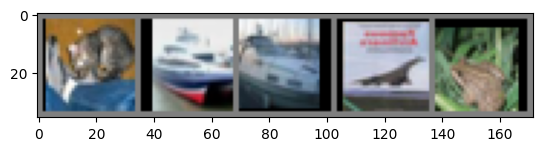

Predicted:  cat ship ship ship deer


In [ ]:
visualize_predictions(model, test_loader, num_images=5)